In [1]:
import tensorflow as tf
import random
import numpy as np    
import matplotlib.pyplot as plt
from scipy.misc import imresize

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
training_epochs = 150
batch_size = 100
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

X = tf.placeholder(tf.float32, shape=[None, 784])
Y = tf.placeholder(tf.float32, shape=[None, 10])
sess = tf.InteractiveSession()

In [3]:
def weight_variable(name, shape):
  #initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.variance_scaling_initializer())

def bias_variable(name, shape):
  #initial = tf.constant(0.1, shape=shape)
  return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.variance_scaling_initializer())

In [4]:
# Why do strides and ksize have dim 4? 
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')


In [5]:
# reshape the input : what's the -1 for?
x_image = tf.reshape(X, [-1,28,28,1])

In [6]:
# First Conv layer : shape = [patch_h, patch_w, input_channel, output_channel]
W_conv1 = weight_variable("C1", [3, 3, 1, 32])
b_conv1 = bias_variable("b1", [32])

# Output of the first conv layer
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
#h_pool1 = max_pool_2x2(h_conv1)
h_pool1=h_conv1

In [7]:
# Second Conv layer
W_conv2 = weight_variable("C2", [3, 3, 32, 64])
b_conv2 = bias_variable("b2", [64])

# Output of the second conv layer
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#h_pool2 = max_pool_2x2(h_conv2)
h_pool2=h_conv2

In [8]:
# Fully connected layer
# W_fc1 = weight_variable("FCW1", [7 * 7 * 64, 1024])
# b_fc1 = bias_variable("FCb1", [1024])

# h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# add a CAM layer instead of a FC layer.
CAMC1 = weight_variable("CAMC1", [3,3,64,64])
CAMb1 = weight_variable("CAMb1", [64])
OUTW = weight_variable("OUTW", [64,10])
OUTb = weight_variable("OUTb", [10])

cam_conv = tf.nn.conv2d(h_pool2, CAMC1, strides=[1,1,1,1], padding='SAME')
cam_conv_relu = tf.nn.relu(tf.nn.bias_add(cam_conv, CAMb1))
cam_conv_dr = tf.nn.dropout(cam_conv_relu, keep_prob)
#gap = tf.nn.avg_pool(cam_conv_dr, ksize=[1,7,7,1], strides=[1,7,7,1], padding = 'SAME')
gap = tf.nn.avg_pool(cam_conv_dr, ksize=[1,28,28,1], strides=[1,28,28,1], padding = 'SAME')
gap_dr = tf.nn.dropout(gap, keep_prob)
gap_vec = tf.reshape(gap_dr, [-1, 64])
out = tf.add(tf.matmul(gap_vec, OUTW), OUTb)
ret = {'gap': gap, 'gap_dr': gap_dr, 'gap_vec': gap_vec, 'out': out}


In [9]:
pred = out
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
corr = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accr = tf.reduce_mean(tf.cast(corr, 'float'))

In [10]:
# Final layer
#W_fc2 = weight_variable("FCW2",[1024, 10])
#b_fc2 = bias_variable("FCb2", [10])

#y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [11]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=3)

for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accr.eval(feed_dict={X:batch[0], Y: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  optm.run(feed_dict={X: batch[0], Y: batch[1], keep_prob: 0.5})
saver.save(sess, './cam_mnist.ckpt', global_step = i)

print("test accuracy %g"%accr.eval(feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1.0}))




step 0, training accuracy 0.12
step 1000, training accuracy 0.8
step 2000, training accuracy 0.88
step 3000, training accuracy 0.96
step 4000, training accuracy 0.94
step 5000, training accuracy 0.98
step 6000, training accuracy 0.96
step 7000, training accuracy 0.94
step 8000, training accuracy 1
step 9000, training accuracy 0.88
step 10000, training accuracy 0.92
step 11000, training accuracy 0.96
step 12000, training accuracy 0.98
step 13000, training accuracy 0.94
step 14000, training accuracy 0.92
step 15000, training accuracy 1
step 16000, training accuracy 1
step 17000, training accuracy 0.98
step 18000, training accuracy 0.96
step 19000, training accuracy 1
test accuracy 0.9755


PREDICTED CLASS : 4
     TRUE CLASS : 4


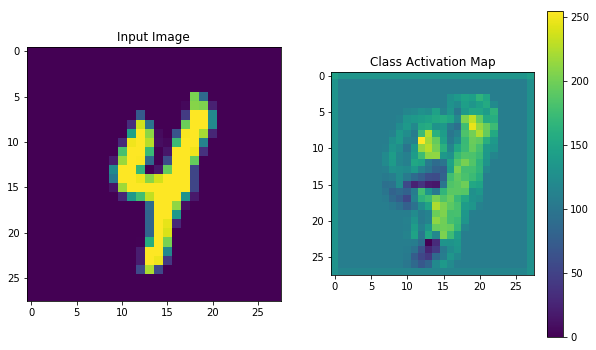

PREDICTED CLASS : 1
     TRUE CLASS : 1


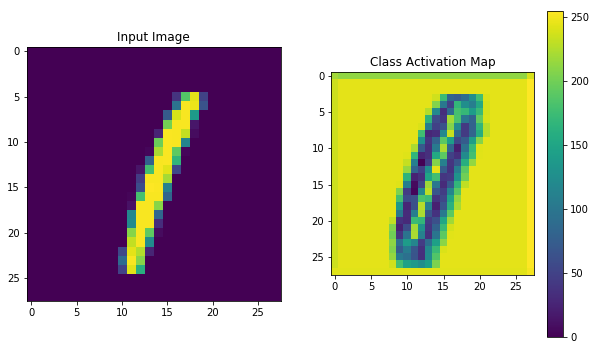

PREDICTED CLASS : 1
     TRUE CLASS : 1


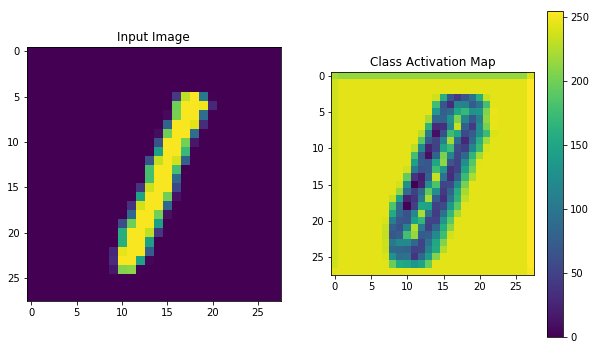

PREDICTED CLASS : 9
     TRUE CLASS : 9


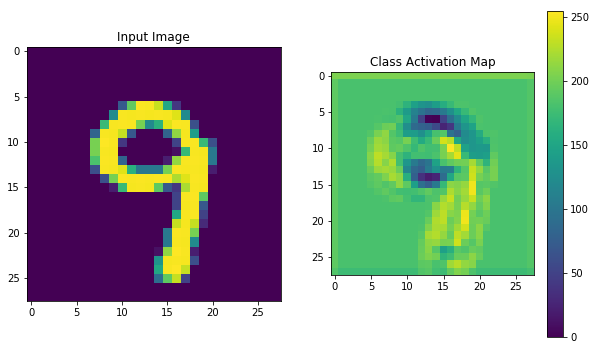

PREDICTED CLASS : 3
     TRUE CLASS : 3


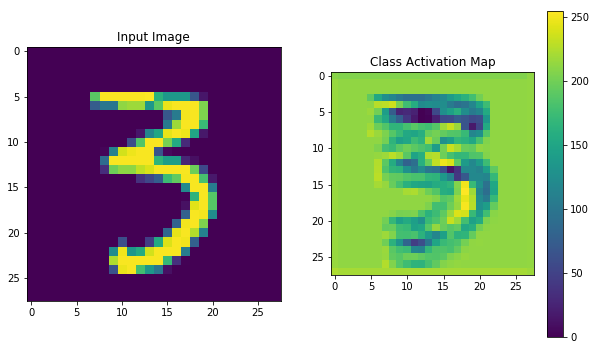

PREDICTED CLASS : 8
     TRUE CLASS : 8


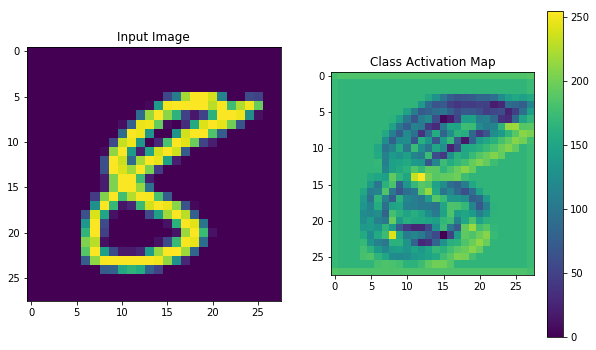

PREDICTED CLASS : 0
     TRUE CLASS : 0


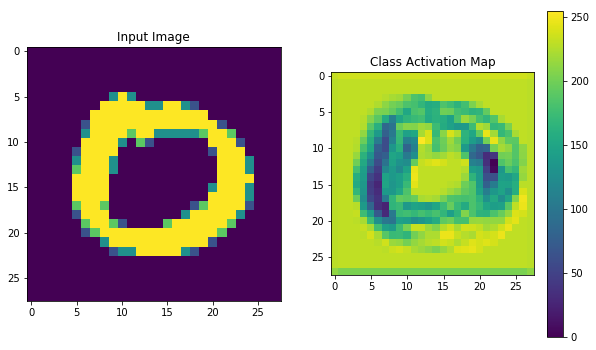

PREDICTED CLASS : 0
     TRUE CLASS : 0


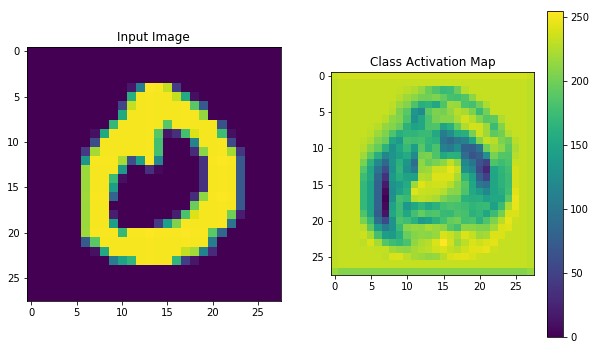

PREDICTED CLASS : 3
     TRUE CLASS : 3


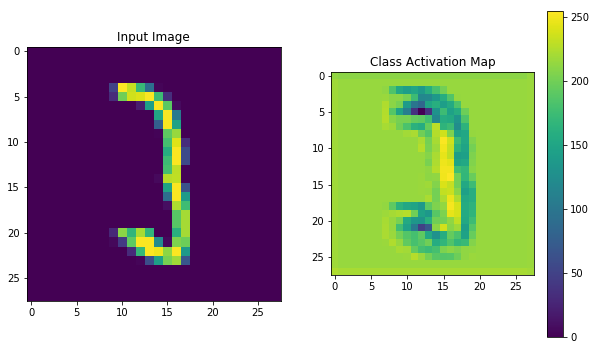

PREDICTED CLASS : 7
     TRUE CLASS : 7


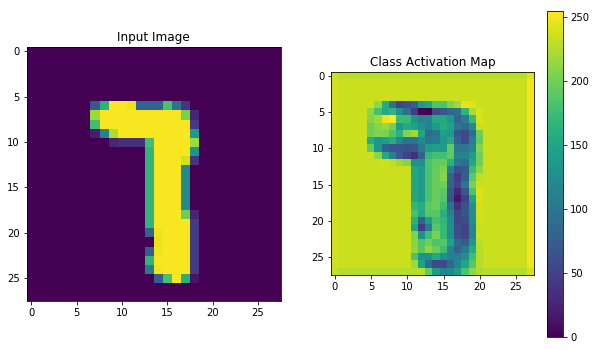

PREDICTED CLASS : 7
     TRUE CLASS : 7


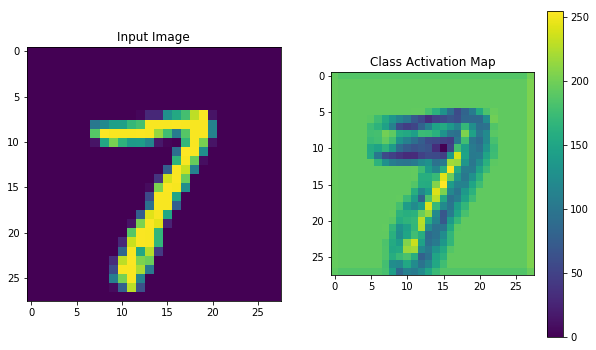

PREDICTED CLASS : 0
     TRUE CLASS : 0


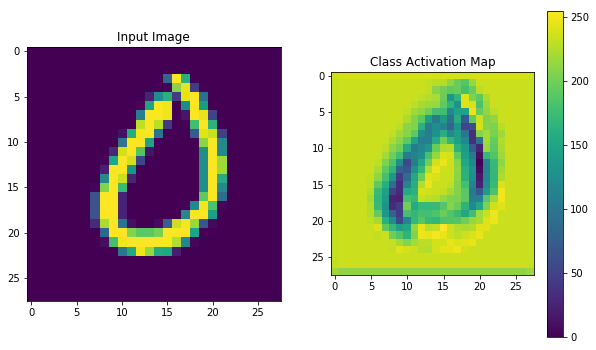

PREDICTED CLASS : 1
     TRUE CLASS : 1


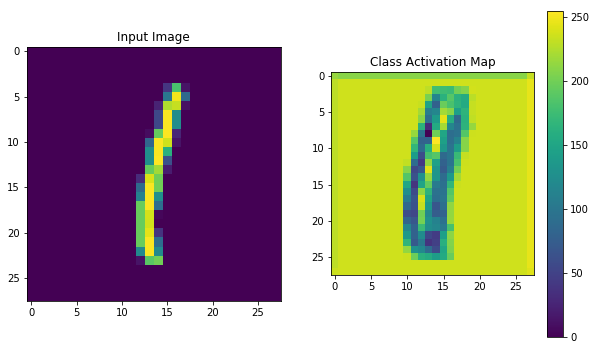

PREDICTED CLASS : 5
     TRUE CLASS : 5


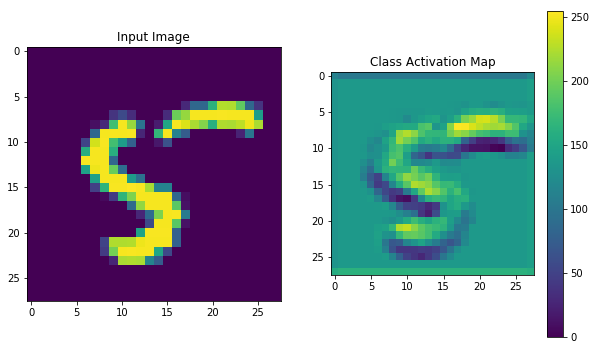

PREDICTED CLASS : 6
     TRUE CLASS : 6


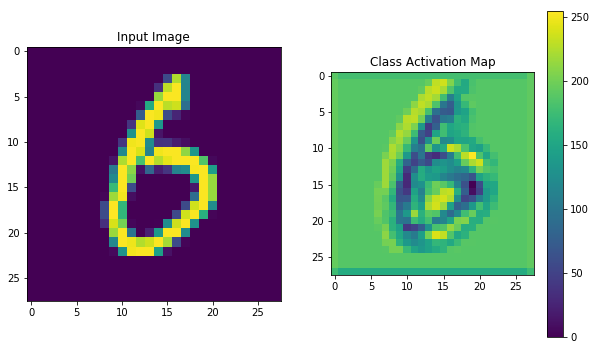

In [13]:
restore_flag = 0
if restore_flag:
    netname = 'cam_mnist.ckpt'
    saver.restore(sess, netname)

ntest = mnist.test.images.shape[0]
randidx = np.random.randint(ntest, size=15)
for idx in randidx:
    testimg = mnist.test.images[idx].reshape(1,784)
    testlabel = np.argmax(mnist.test.labels[idx])

    cam_testfeat, cam_outval, cam_weights = sess.run([h_pool2, pred, OUTW], feed_dict={X: testimg, keep_prob: 1.})
    predlabel = np.argmax(cam_outval)
    predweights = cam_weights[:, predlabel]
    #camsum = np.zeros((7, 7))
    camsum = np.zeros((28,28))
    for i in xrange(64): 
        camsum = camsum + predweights[i] * cam_testfeat[0,:,:,i]
    camavg = camsum / 64

    print "PREDICTED CLASS : %d" % (predlabel)
    print "     TRUE CLASS : %d" % (testlabel)
    # PLOT
    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(1,2,1)
    ax1.imshow(testimg[0].reshape((28,28)))
    ax1.set_title("Input Image")
    ax2 = fig1.add_subplot(1,2,2)     
    im2 = ax2.imshow(imresize(camavg,[28,28]), origin='upper')
    ax2.set_title("Class Activation Map")
    plt.colorbar(im2, ax=ax2)
    plt.show()